In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

from loadData import load_data
from rho_spec import rho_spec
from surfaceNormal import (
    surface_normal_from_zenith_azimuth,
    compute_surface_normals
)
from plot_utils import (
    show_reference_normal_colors,
    visualize_normals_rgb,
    visualize_aolp,
    visualize_dolp
)

▶ Processing red_transparent


/opt/anaconda3/envs/polartact/lib/python3.13/site-packages/polanalyser/stokes.py:173: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(s1**2 + s2**2) / s0


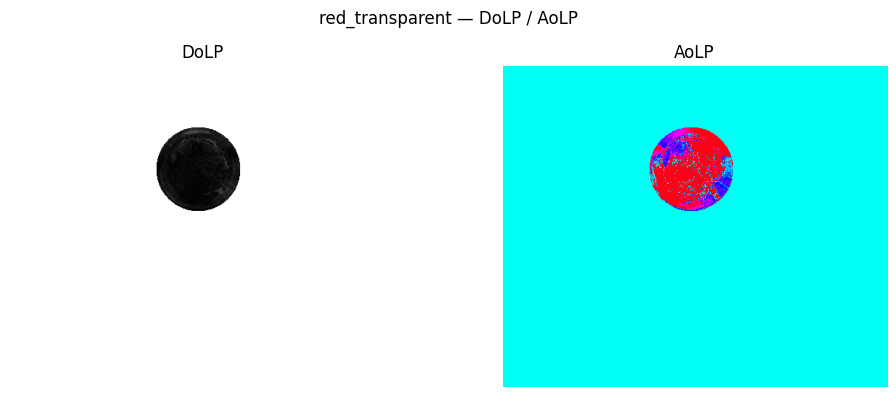

▶ Processing single_shell


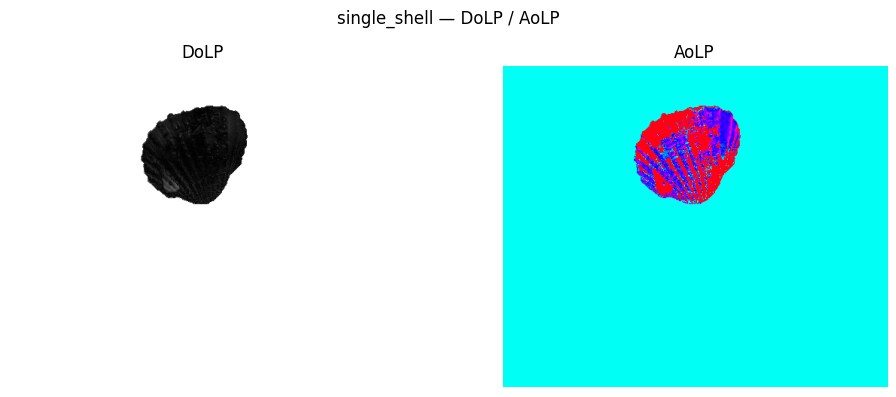

▶ Processing stone_white


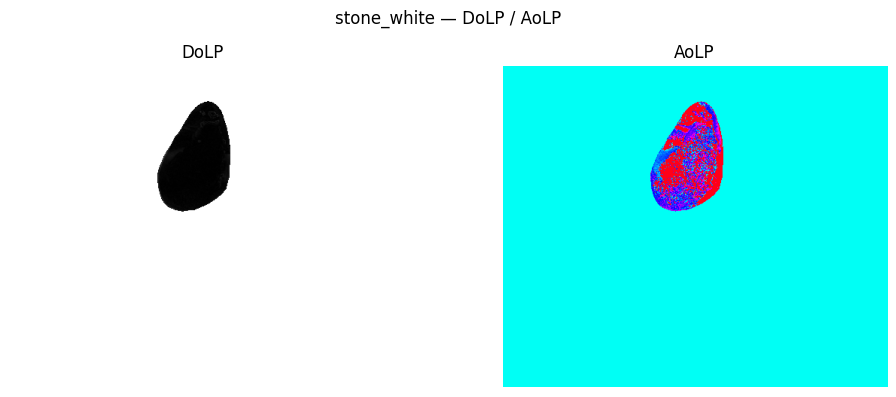

In [2]:
import cv2
import numpy as np
import polanalyser as pa
import matplotlib.pyplot as plt

# List of filenames (with extension)
objects = ['red_transparent', 'single_shell', 'stone_white']

for object in objects:
    print(f"▶ Processing {object}")

    # Read polarization images
    img_000 = cv2.imread(f'../data/masked_pol_img/pol000/{object}.png')
    img_045 = cv2.imread(f'../data/masked_pol_img/pol045/{object}.png')
    img_090 = cv2.imread(f'../data/masked_pol_img/pol090/{object}.png')
    img_135 = cv2.imread(f'../data/masked_pol_img/pol135/{object}.png')

    # Convert to grayscale
    gray_000 = cv2.cvtColor(img_000, cv2.COLOR_BGR2GRAY)
    gray_045 = cv2.cvtColor(img_045, cv2.COLOR_BGR2GRAY)
    gray_090 = cv2.cvtColor(img_090, cv2.COLOR_BGR2GRAY)
    gray_135 = cv2.cvtColor(img_135, cv2.COLOR_BGR2GRAY)

    # Calculate the Stokes vector
    image_list = [gray_000, gray_045, gray_090, gray_135]
    angles = np.deg2rad([0, 45, 90, 135])
    stokes = pa.calcStokes(image_list, angles)

    # Convert to DoLP and AoLP
    dolp = pa.cvtStokesToDoLP(stokes)
    aolp = pa.cvtStokesToAoLP(stokes)

    # Optional: visualize
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"{object} — DoLP / AoLP")

    plt.subplot(1, 2, 1)
    plt.imshow(dolp, cmap='gray')
    plt.title('DoLP'); plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aolp, cmap='hsv', vmin=-np.pi/2, vmax=np.pi/2)
    plt.title('AoLP'); plt.axis('off')

    plt.tight_layout()
    plt.show()

Normals shape: (428, 512, 3)


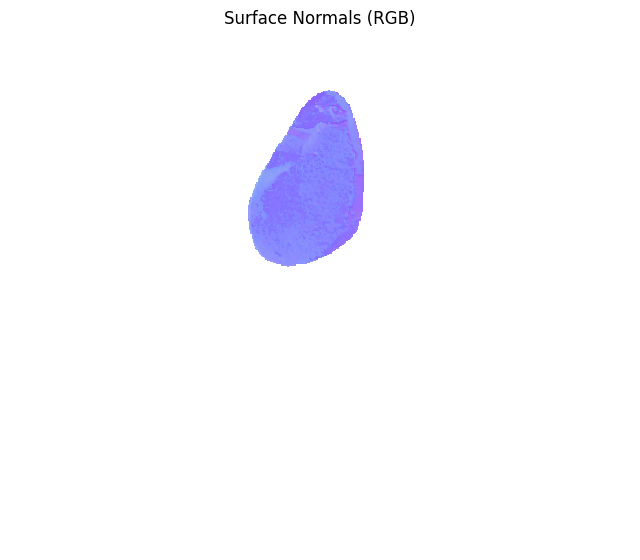

In [3]:
# === Refractive Index ===
n = 1.5

# Estimate zenith angle (theta) from DoLP
theta = rho_spec(dolp, n)  # or rho_diffuse(dolp, n)

mask = None

# === Compute Surface Normals ===
normals = surface_normal_from_zenith_azimuth(theta, aolp)
if mask is not None:
    normals[mask == 0] = 0
if normals.shape[-1] == 3 and normals.shape[-2] == 3:
    normals = normals[..., 0]
print("Normals shape:", normals.shape)
assert normals.shape[-1] == 3 and normals.ndim == 3  # (H, W, 3)

"""
# === Print Sample Normals ===
print("Sample surface normal vectors:")
for i in range(0, normals.shape[0], 100):
    for j in range(0, normals.shape[1], 100):
        print(f"normal[{i},{j}] = {normals[i, j]}")
   

print("Theta: min =", theta.min(), "max =", theta.max(), "mean =", theta.mean())
print("Azimuth: min =", aolp.min(), "max =", aolp.max(), "mean =", aolp.mean())
"""

# === Visualize ===
#visualize_dolp(dolp)
#visualize_aolp(aolp)

visualize_normals_rgb(normals)
#show_reference_normal_colors()


In [4]:
print(len(np.unique(normals)))
normals.dtype

20101


dtype('float64')

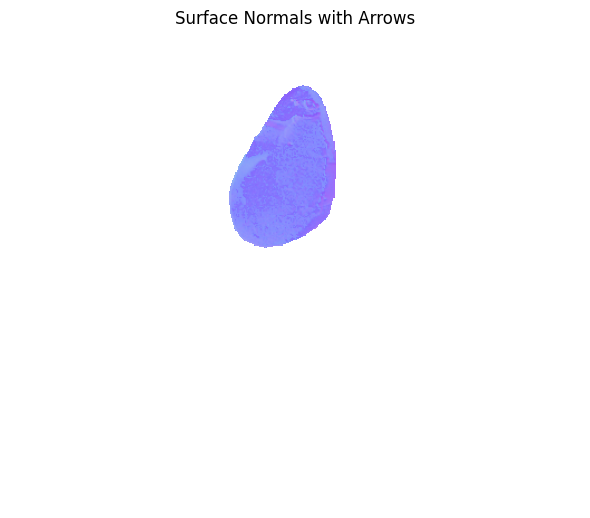

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assume normals is (H, W, 3)
H, W = normals.shape[:2]
nx, ny, nz = normals[..., 0], normals[..., 1], normals[..., 2]

# Subsample for readability
step = 10
y, x = np.mgrid[0:H:step, 0:W:step]
u = nx[::step, ::step]
v = ny[::step, ::step]

# Optional background: convert normals to RGB
normal_rgb = ((normals + 1) / 2).clip(0, 1)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(normal_rgb, origin='upper')
# plt.quiver(x, y, u, -v, color='red', scale=20, headwidth=3)
plt.axis('off')
plt.title("Surface Normals with Arrows")
plt.tight_layout()
plt.show()

▶ Processing red_transparent


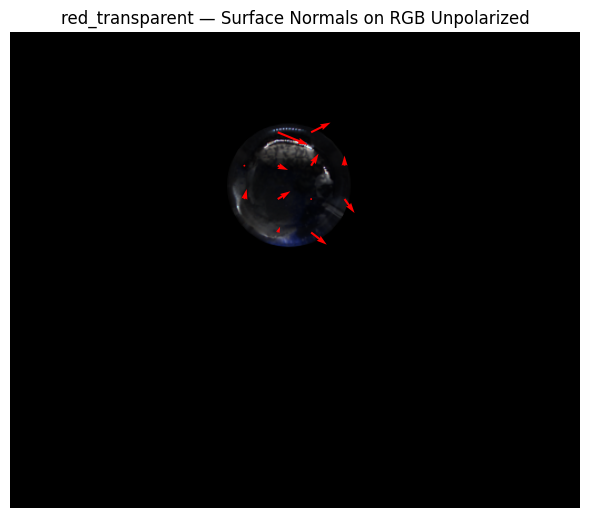

▶ Processing single_shell


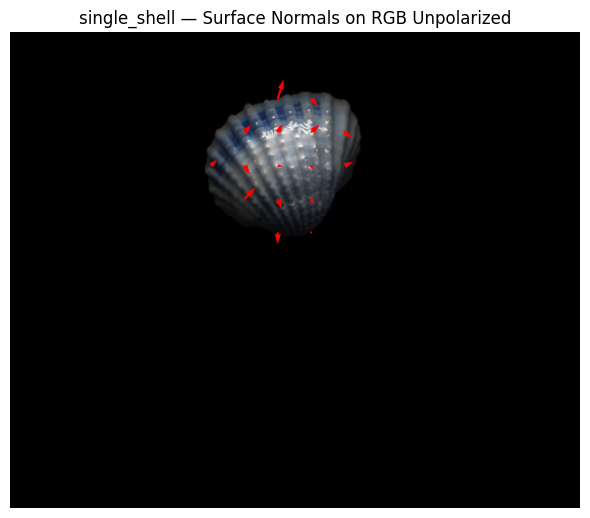

▶ Processing stone_white


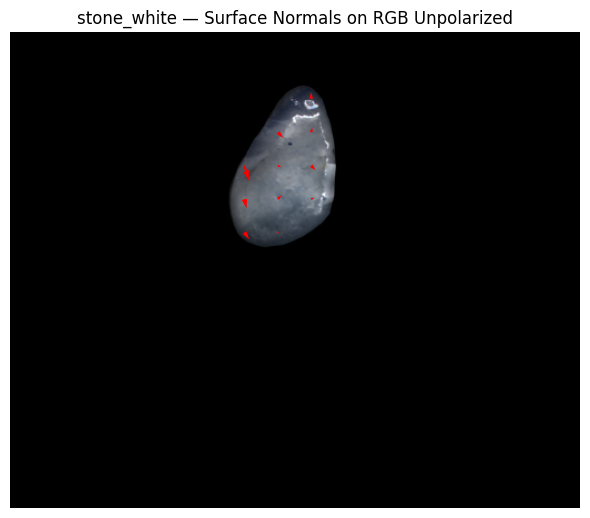

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import polanalyser as pa
from rho_spec import rho_spec
from surfaceNormal import surface_normal_from_zenith_azimuth

objects = ['red_transparent', 'single_shell', 'stone_white']
base_path = "../data/masked_pol_img"
angles = np.deg2rad([0, 45, 90, 135])
n = 1.5
step = 30

for object in objects:
    print(f"▶ Processing {object}")

    # Read polarization images
    img_000 = cv2.imread(f'../data/masked_pol_img/pol000/{object}.png')
    img_045 = cv2.imread(f'../data/masked_pol_img/pol045/{object}.png')
    img_090 = cv2.imread(f'../data/masked_pol_img/pol090/{object}.png')
    img_135 = cv2.imread(f'../data/masked_pol_img/pol135/{object}.png')

    # Compute unpolarized RGB image
    unpolarized = np.mean([img_000, img_045, img_090, img_135], axis=0) / 255.0

    # Convert to grayscale for Stokes processing
    gray_000 = cv2.cvtColor(img_000.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray_045 = cv2.cvtColor(img_045.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray_090 = cv2.cvtColor(img_090.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray_135 = cv2.cvtColor(img_135.astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Compute Stokes and normals
    stokes = pa.calcStokes([gray_000, gray_045, gray_090, gray_135], angles)
    dolp = pa.cvtStokesToDoLP(stokes)
    aolp = pa.cvtStokesToAoLP(stokes)
    theta = rho_spec(dolp, n)
    normals = surface_normal_from_zenith_azimuth(theta, aolp)

    # Quiver grid
    nx, ny = normals[..., 0], normals[..., 1]
    H, W = nx.shape
    y, x = np.mgrid[0:H:step, 0:W:step]
    u = nx[::step, ::step]
    v = ny[::step, ::step]

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(unpolarized, origin='upper')
    plt.quiver(x, y, u, -v, color='red', scale=10, headwidth=3)
    plt.title(f"{object} — Surface Normals on RGB Unpolarized")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, polanalyser as pa
from rho_spec import rho_spec
from surfaceNormal import surface_normal_from_zenith_azimuth

# ---------- CONFIG -----------------------------------------------------
filenames   = ['red_transparent.png', 'single_shell.png', 'stone_white.png']
base_path   = "../data/masked_pol_img"
save_base   = "demo_results"
angles      = np.deg2rad([0, 45, 90, 135])
n_refrac    = 1.5
step        = 30               # quiver stride

# make output dirs
for d in ["unpolar", "unpolar_arrows", "dolp", "aolp", "normal_rgb"]:
    os.makedirs(f"{save_base}/{d}", exist_ok=True)

# ---------- MAIN LOOP --------------------------------------------------
for fname in filenames:
    print(f"▶ {fname}")
    rgb_pol = [
        cv2.cvtColor(cv2.imread(f"{base_path}/pol{ang:03}/{fname}"), cv2.COLOR_BGR2RGB).astype(np.float32)
        for ang in (0, 45, 90, 135)
    ]

    # Unpolar RGB
    unpolar = np.mean(rgb_pol, axis=0) / 255.0         # [0-1] float

    # Grays for Stokes
    grays = [cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY) for img in rgb_pol]
    stokes = pa.calcStokes(grays, angles)
    dolp   = pa.cvtStokesToDoLP(stokes)
    aolp   = pa.cvtStokesToAoLP(stokes)

    # Normals
    theta   = rho_spec(dolp, n_refrac)
    normals = surface_normal_from_zenith_azimuth(theta, aolp)
    nx, ny  = normals[...,0], normals[...,1]

    # ---------- SAVE DOLP ----------
    cv2.imwrite(f"{save_base}/dolp/{fname}", (dolp*255).astype(np.uint8))

    # ---------- SAVE AoLP (HSV → BGR) ----------
    aolp_norm = (aolp + np.pi/2) / np.pi          # 0-1
    hue  = (aolp_norm * 179).astype(np.uint8)     # 0-179
    sat  = np.full_like(hue, 255, np.uint8)
    val  = np.full_like(hue, 255, np.uint8)
    hsv  = cv2.merge([hue, sat, val])             # H,S,V
    aolp_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imwrite(f"{save_base}/aolp/{fname}", aolp_bgr)

    # ---------- SAVE normal_rgb ----------
    normal_rgb = ((normals + 1)/2).clip(0,1)
    cv2.imwrite(f"{save_base}/normal_rgb/{fname}",
                cv2.cvtColor((normal_rgb*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    # ---------- SAVE unpolar (no arrows) ----------
    cv2.imwrite(f"{save_base}/unpolar/{fname}",
                cv2.cvtColor((unpolar*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    # ---------- SAVE unpolar with quiver arrows ----------
    H, W = nx.shape
    ys, xs = np.mgrid[0:H:step, 0:W:step]
    u, v  = nx[::step, ::step], ny[::step, ::step]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(unpolar, origin='upper')
    ax.quiver(xs, ys, u, -v, color='red', scale=20, headwidth=3)
    ax.axis('off')

    out_path = f"{save_base}/unpolar_arrows/{fname}"
    fig.savefig(out_path, dpi=150, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

▶ red_transparent.png
▶ single_shell.png


/var/folders/yx/jx_z889n6dg9dzyx9rzsdnv80000gn/T/ipykernel_87998/3878442828.py:40: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(f"{save_base}/dolp/{fname}", (dolp*255).astype(np.uint8))
/var/folders/yx/jx_z889n6dg9dzyx9rzsdnv80000gn/T/ipykernel_87998/3878442828.py:54: RuntimeWarning: invalid value encountered in cast
  cv2.cvtColor((normal_rgb*255).astype(np.uint8), cv2.COLOR_RGB2BGR))


▶ stone_white.png
